## Fit Baker et al data with dynamical model with multiplicative adaptation and sine-rebound responses

$$\tau_r \frac{dr}{dt} = -r + x_s(1-a_s)I_s(t) + x_p(1-a_p)I_p(t) + a_s x_{qs}I_{qs}(t) + a_s x_{ps}I_{ps}(t)$$

$$\tau_a \frac{da_s}{dt} = -a_s + I_s(t) \quad \quad \quad \tau_a \frac{da_p}{dt} = -a_p + I_p(t)$$

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, signal, stats
import sys

from disp import set_plot
from record_1_ma_ext import smlt_masrb

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NNRN = 224
ALPHA = 100

FSAVE = 'data/simple/neur/baker_masrb.npy'

In [2]:
# load data
DF_S = pd.read_csv('data/simple/neur/baker_resampled_s.csv')
DF_P = pd.read_csv('data/simple/neur/baker_resampled_p.csv')

I_S = np.array(DF_S['S'])
I_P = np.array(DF_P['P'])

R_SS = np.array(DF_S[[f'R_{cnrn}' for cnrn in range(NNRN)]])
R_PS = np.array(DF_P[[f'R_{cnrn}' for cnrn in range(NNRN)]])

T = np.arange(len(I_S))*DT

In [3]:
nrns_fit = range(NNRN)
# nrns_fit = [13, 14, 34, 35, 37, 38, 40] + [57, 60, 61, 62, 63, 64, 65, 66, 67, 74, 85, 86, 87, 98, 110, 118, 146, 147, 162, 174, 198, 209]
# nrns_fit = [13, 14, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 120]

In [4]:
# initial params
params_init_dflt = {'TAU_R': 2, 'TAU_A': 5, 'X_S': 1, 'X_P': 1, 'X_QS': 0, 'X_PS': 0}
params_init = {
    48: {'TAU_R': 2, 'TAU_A': 5, 'X_S': 10, 'X_P': 1, 'X_QS': 0, 'X_PS': 0},
    49: {'TAU_R': 2, 'TAU_A': 5, 'X_S': 10, 'X_P': 1, 'X_QS': 0, 'X_PS': 0},
    52: {'TAU_R': 7, 'TAU_A': 100, 'X_S': -3, 'X_P': -3, 'X_QS': 0, 'X_PS': 0},
    57: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 7, 'X_P': 0, 'X_QS': 7, 'X_PS': 0},
    60: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 7, 'X_P': 0, 'X_QS': 7, 'X_PS': 0},
    61: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 7, 'X_P': 0, 'X_QS': 7, 'X_PS': 0},
    62: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 7, 'X_P': 0, 'X_QS': 7, 'X_PS': 0},
    63: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 7, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    64: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 7, 'X_P': 0, 'X_QS': 7, 'X_PS': 0},
    65: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 3, 'X_P': -2, 'X_QS': 7, 'X_PS': 0},
    66: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 9, 'X_P': 0, 'X_QS': 9, 'X_PS': 0},
    67: {'TAU_R': 1, 'TAU_A': 1, 'X_S': 9, 'X_P': 0, 'X_QS': 9, 'X_PS': 0},
    74: {'TAU_R': 2, 'TAU_A': 5, 'X_S': 0, 'X_P': 5, 'X_QS': 7, 'X_PS': 0},
    76: {'TAU_R': 2, 'TAU_A': 5, 'X_S': 5, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    77: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 3, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    78: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    79: {'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    80: {'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    81: {'TAU_R': 1, 'TAU_A': 3.5, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    82: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    101: {'TAU_R': 7, 'TAU_A': 2, 'X_S': -3, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    104: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 3, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    105: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 2, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    106: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    107: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    108: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    109: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    110: {'TAU_R': 10, 'TAU_A': .1, 'X_S': 10, 'X_P': -5, 'X_QS': 0, 'X_PS': 0},
    112: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': -3, 'X_QS': 0, 'X_PS': 0},
    118: {'TAU_R': .5, 'TAU_A': 2, 'X_S': 3, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    141: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 13, 'X_P': 2, 'X_QS': 0, 'X_PS': 0},
    142: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    143: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    144: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    145: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    146: {'TAU_R': 5, 'TAU_A': .1, 'X_S': 3, 'X_P': 3, 'X_QS': 0, 'X_PS': 0},
    147: {'TAU_R': 5, 'TAU_A': .1, 'X_S': 2, 'X_P': 2, 'X_QS': 0, 'X_PS': 0},
    148: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 10, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    160: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 10, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    162: {'TAU_R': .5, 'TAU_A': .1, 'X_S': 10, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    164: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': 3, 'X_QS': 0, 'X_PS': 0},
    165: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 5, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    168: {'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 8, 'X_QS': 0, 'X_PS': 0},
    169: {'TAU_R': 1, 'TAU_A': 5, 'X_S': 0, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    170: {'TAU_R': 1, 'TAU_A': 5, 'X_S': 0, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    171: {'TAU_R': 1, 'TAU_A': 5, 'X_S': 0, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    173: {'TAU_R': 1, 'TAU_A': 5, 'X_S': 0, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    174: {'TAU_R': 2, 'TAU_A': .1, 'X_S': 10, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    176: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    177: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    178: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    179: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    180: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    182: {'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 5, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    183: {'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    184: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    185: {'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    191: {'TAU_R': 5, 'TAU_A': 1, 'X_S': 15, 'X_P': 3, 'X_QS': 0, 'X_PS': 0},
    198: {'TAU_R': 5, 'TAU_A': 1, 'X_S': 15, 'X_P': 3, 'X_QS': 0, 'X_PS': 0},
    200: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 5, 'X_P': 5, 'X_QS': 0, 'X_PS': 0},
    201: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0, 'X_QS': 0, 'X_PS': 0},
    202: {'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    204: {'TAU_R': .7, 'TAU_A': 3, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    205: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    206: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    207: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    208: {'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10, 'X_QS': 0, 'X_PS': 0},
    209: {'TAU_R': 5, 'TAU_A': 1, 'X_S': 3, 'X_P': 15, 'X_QS': 0, 'X_PS': 0},
    210: {'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 3, 'X_QS': 0, 'X_PS': 0},
}

for inrn in range(NNRN):
    if inrn not in params_init:
        params_init[inrn] = params_init_dflt

In [5]:
# objective function for MA fit
def obj_masrb(param, r_s, r_p):
    tau_r, tau_a, x_s, x_p, x_qs = param  # note we do not include x_ps
    
    params_temp = {
        'TAU_R': np.array([tau_r]), 'TAU_A': np.array([tau_a]),
        'X_S': np.array([x_s]), 'X_P': np.array([x_p]),
        'X_QS': np.array([x_qs]), 'X_PS': np.array([0]),
    }
    
    r_smln_s = smlt_masrb(I_S, 0*I_P, params_temp, DT)[:, 0]
    r_smln_p = smlt_masrb(0*I_S, I_P, params_temp, DT)[:, 0]
    
    # compute error
    mse = np.nanmean(cc([r_s-r_smln_s, r_p-r_smln_p])**2)
    return mse

bounds = [(.001, None), (.001, None), (-15, 15), (-15, 15), (-15, 15)]

In [6]:
# loop over expt_ids
tau_rs = np.nan*np.zeros(NNRN)
tau_as = np.nan*np.zeros(NNRN)
x_ss = np.nan*np.zeros(NNRN)
x_ps = np.nan*np.zeros(NNRN)
x_qs_all = np.nan*np.zeros(NNRN)
x_ps_all = np.nan*np.zeros(NNRN)

for cnrn, inrn in enumerate(nrns_fit):
    sys.stdout.write('.')
    
    r_s = R_SS[:, inrn].copy()
    r_p = R_PS[:, inrn].copy()
        
    param = params_init[inrn]
    x_0 = [param['TAU_R'], param['TAU_A'], param['X_S'], param['X_P'], param['X_QS']]
    
    # fit model
    np.random.seed(0)
    fit_rslt = optimize.minimize(obj_masrb, x_0, args=(r_s, r_p), bounds=bounds)

    # unpack params
    tau_r, tau_a, x_s, x_p, x_qs = fit_rslt.x
    
    tau_rs[inrn] = tau_r
    tau_as[inrn] = tau_a
    x_ss[inrn] = x_s
    x_ps[inrn] = x_p
    x_qs_all[inrn] = x_qs
    x_ps_all[inrn] = 0

................................................................................................................................................................................................................................

In [7]:
params_0 = {
    'EXPT_ID': range(NNRN),
    'TAU_R': np.array([params_init[inrn]['TAU_R'] for inrn in range(NNRN)]),
    'TAU_A': np.array([params_init[inrn]['TAU_A'] for inrn in range(NNRN)]),
    'X_S': np.array([params_init[inrn]['X_S'] for inrn in range(NNRN)]),
    'X_P': np.array([params_init[inrn]['X_P'] for inrn in range(NNRN)]),
    'X_QS': np.array([params_init[inrn]['X_QS'] for inrn in range(NNRN)]),
    'X_PS': np.array([params_init[inrn]['X_PS'] for inrn in range(NNRN)]),
}

params_1 = {
    'EXPT_ID': range(NNRN),
    'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps, 'X_QS': x_qs_all, 'X_PS': x_ps_all
}

# Examine fits

In [8]:
r_smln_s_0s = smlt_masrb(I_S, 0*I_P, params_0, DT)
r_smln_p_0s = smlt_masrb(0*I_S, I_P, params_0, DT)

r_smln_s_1s = smlt_masrb(I_S, 0*I_P, params_1, DT)
r_smln_p_1s = smlt_masrb(0*I_S, I_P, params_1, DT)

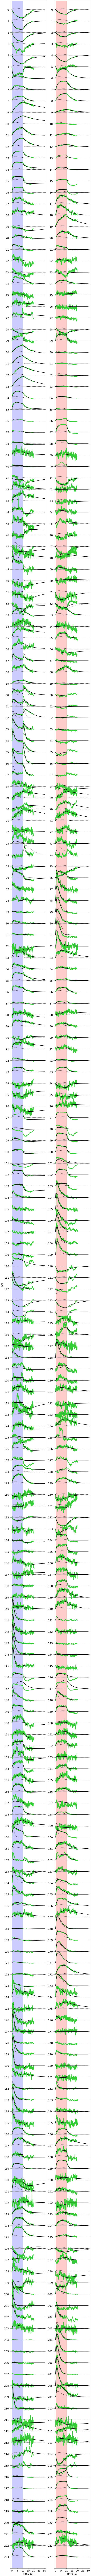

In [9]:
t = np.arange(len(R_SS))*DT

nplot = len(nrns_fit)
fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cnrn, inrn in enumerate(nrns_fit):
    y_tick = -4*cnrn
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, inrn] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_smln_s_0s[:, inrn] + y_tick, c='k', lw=1, ls='--')  # simulated from initial params
    axs[0].plot(t, r_smln_s_1s[:, inrn] + y_tick, c='k', lw=2, ls='-')  # simulated from fit params
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, inrn] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_smln_p_0s[:, inrn] + y_tick, c='k', lw=1, ls='--')  # simulated from initial params
    axs[1].plot(t, r_smln_p_1s[:, inrn] + y_tick, c='k', lw=2, ls='-')  # simulated from initial params
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*nplot, 3), y_ticks=y_ticks, y_tick_labels=nrns_fit, x_label='Time (s)', font_size=16)

In [10]:
np.save(FSAVE, np.array([params_1]))

# Parameter distributions

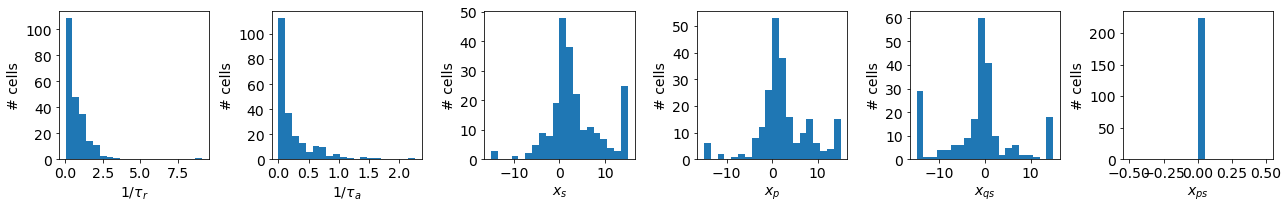

In [11]:
fig, axs = plt.subplots(1, 6, figsize=(18, 3), tight_layout=True)
axs[0].hist(1/tau_rs, bins=20)
axs[0].set_xlabel(r'$1/\tau_r$')

axs[1].hist(1/tau_as, bins=20)
axs[1].set_xlabel(r'$1/\tau_a$')

axs[2].hist(x_ss, bins=20)
axs[2].set_xlabel(r'$x_s$')

axs[3].hist(x_ps, bins=20)
axs[3].set_xlabel(r'$x_p$')

axs[4].hist(x_qs_all, bins=20)
axs[4].set_xlabel(r'$x_{qs}$')

axs[5].hist(x_ps_all, bins=20)
axs[5].set_xlabel(r'$x_{ps}$')

for ax in axs:
    set_plot(ax, y_label='# cells', font_size=14)